# Analisis de datos de viajes en medios de transporte publico en CABA

#### Tomo como referencia notebooks vistos en clase y sumo otros scripts investigados individualmente
#### pySpark Commands Reference
https://spark.apache.org/docs/2.4.4/api/python/index.html


#### Connect to Spark Cluster
https://github.com/minrk/findspark

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
spark = (
    SparkSession.builder
    .appName("pyspark-df-overview")
    .config("spark.driver.memory", "512m")
    .config("spark.driver.cores", "1")
    .config("spark.executor.memory", "512m")
    .config("spark.executor.cores", "1")
    .config("spark.sql.shuffle.partitions", "2")
    .getOrCreate()
)

In [3]:
spark.version

'2.4.5'

### Creo un Spark DataFrame
Dataset: https://data.buenosaires.gob.ar/dataset/sube/resource/b88f4c3d-325d-4397-93ff-c54657357092

In [4]:
df = spark.read.csv("/dataset/dataset_viajes_sube.csv", header=True)
df.printSchema()

root
 |-- TIPO_TRANSPORTE: string (nullable = true)
 |-- DIA: string (nullable = true)
 |-- PARCIAL: string (nullable = true)
 |-- CANTIDAD: string (nullable = true)



### Define a schema

In [5]:
import pyspark.sql.types as t

viajes_schema = t.StructType([
      t.StructField('TIPO_TRANSPORTE', t.StringType(), True)
    , t.StructField('DIA', t.StringType(), True)
    , t.StructField('PARCIAL', t.StringType(), True)
    , t.StructField('CANTIDAD', t.IntegerType(), True)
])

In [6]:
# Support for compressed (gziped) payload
df = spark.read.csv("/dataset/dataset_viajes_sube.csv", header=True, schema=viajes_schema)
df.printSchema()

root
 |-- TIPO_TRANSPORTE: string (nullable = true)
 |-- DIA: string (nullable = true)
 |-- PARCIAL: string (nullable = true)
 |-- CANTIDAD: integer (nullable = true)



In [7]:
df.count()

1835

### Modifico el campo de la fecha para poder trabajarlo y elimino los que no voy a usar

In [8]:
from pyspark.sql.functions import split
dfDate = df.withColumn("fecha", split("DIA", ":").getItem(0))
dfDate.show()



+---------------+------------------+-------+--------+---------+
|TIPO_TRANSPORTE|               DIA|PARCIAL|CANTIDAD|    fecha|
+---------------+------------------+-------+--------+---------+
|          Subte|31MAR2020:00:00:00|   null|    null|31MAR2020|
|          Subte|01APR2020:00:00:00|   null|    null|01APR2020|
|          Subte|02APR2020:00:00:00|   null|    null|02APR2020|
|          Subte|03APR2020:00:00:00|   null|    null|03APR2020|
|          Subte|04APR2020:00:00:00|   null|    null|04APR2020|
|          Subte|05APR2020:00:00:00|   null|    null|05APR2020|
|          Subte|06APR2020:00:00:00|   null|    null|06APR2020|
|          Subte|07APR2020:00:00:00|   null|    null|07APR2020|
|          Subte|08APR2020:00:00:00|   null|    null|08APR2020|
|          Subte|09APR2020:00:00:00|   null|    null|09APR2020|
|          Subte|10APR2020:00:00:00|   null|    null|10APR2020|
|          Subte|11APR2020:00:00:00|   null|    null|11APR2020|
|          Subte|12APR2020:00:00:00|   n

In [9]:
import pandas as pd

dfFecha = dfDate.toPandas()

dfFecha['dia2'] = dfFecha['fecha'].str.extract('(\d\d)', expand = True) 
dfFecha['mes'] = dfFecha['fecha'].str.extract('\d\d(\w\w\w)', expand=True) 
dfFecha['anio'] = dfFecha['fecha'].str.extract('(\d\d\d\d)', expand=True) 
dfFecha['CANTIDAD'] = dfFecha['CANTIDAD'].fillna(0)

print(dfFecha) 

     TIPO_TRANSPORTE                 DIA PARCIAL  CANTIDAD      fecha dia2  \
0              Subte  31MAR2020:00:00:00    None       0.0  31MAR2020   31   
1              Subte  01APR2020:00:00:00    None       0.0  01APR2020   01   
2              Subte  02APR2020:00:00:00    None       0.0  02APR2020   02   
3              Subte  03APR2020:00:00:00    None       0.0  03APR2020   03   
4              Subte  04APR2020:00:00:00    None       0.0  04APR2020   04   
...              ...                 ...     ...       ...        ...  ...   
1830           Subte  25SEP2021:00:00:00    True  230834.0  25SEP2021   25   
1831           Subte  26SEP2021:00:00:00    True  133714.0  26SEP2021   26   
1832            Tren  25SEP2021:00:00:00   False  516037.0  25SEP2021   25   
1833            Tren  26SEP2021:00:00:00   False  239172.0  26SEP2021   26   
1834            Tren  27SEP2021:00:00:00    True  829845.0  27SEP2021   27   

      mes  anio  
0     MAR  2020  
1     APR  2020  
2     APR

In [10]:
dfFecha['dia2'] = pd.to_numeric(dfFecha['dia2'])
dfFecha['anio'] = pd.to_numeric(dfFecha['anio'])
dfFecha['CANTIDAD'] = pd.to_numeric(dfFecha['CANTIDAD'])

In [11]:
dfsFecha = spark.createDataFrame(dfFecha)
dfsFecha.show(169)

+---------------+------------------+-------+---------+---------+----+---+----+
|TIPO_TRANSPORTE|               DIA|PARCIAL| CANTIDAD|    fecha|dia2|mes|anio|
+---------------+------------------+-------+---------+---------+----+---+----+
|          Subte|31MAR2020:00:00:00|   null|      0.0|31MAR2020|  31|MAR|2020|
|          Subte|01APR2020:00:00:00|   null|      0.0|01APR2020|   1|APR|2020|
|          Subte|02APR2020:00:00:00|   null|      0.0|02APR2020|   2|APR|2020|
|          Subte|03APR2020:00:00:00|   null|      0.0|03APR2020|   3|APR|2020|
|          Subte|04APR2020:00:00:00|   null|      0.0|04APR2020|   4|APR|2020|
|          Subte|05APR2020:00:00:00|   null|      0.0|05APR2020|   5|APR|2020|
|          Subte|06APR2020:00:00:00|   null|      0.0|06APR2020|   6|APR|2020|
|          Subte|07APR2020:00:00:00|   null|      0.0|07APR2020|   7|APR|2020|
|          Subte|08APR2020:00:00:00|   null|      0.0|08APR2020|   8|APR|2020|
|          Subte|09APR2020:00:00:00|   null|      0.

In [12]:
dfsFecha.printSchema()

root
 |-- TIPO_TRANSPORTE: string (nullable = true)
 |-- DIA: string (nullable = true)
 |-- PARCIAL: string (nullable = true)
 |-- CANTIDAD: double (nullable = true)
 |-- fecha: string (nullable = true)
 |-- dia2: long (nullable = true)
 |-- mes: string (nullable = true)
 |-- anio: long (nullable = true)



In [13]:
dfsFecha = dfsFecha.drop('DIA', 'fecha')
dfsFecha.printSchema()

root
 |-- TIPO_TRANSPORTE: string (nullable = true)
 |-- PARCIAL: string (nullable = true)
 |-- CANTIDAD: double (nullable = true)
 |-- dia2: long (nullable = true)
 |-- mes: string (nullable = true)
 |-- anio: long (nullable = true)



In [14]:
##Comienzo a analizar los datos

In [15]:
from pyspark.sql.functions import avg, desc, sum

dfsFecha.groupBy(['TIPO_TRANSPORTE', 'anio']). \
agg(
    sum('CANTIDAD').alias('cantidad_viajes'),
    avg('CANTIDAD').alias('promedio_viajes')
).orderBy(desc('cantidad_viajes')). \
show()

+---------------+----+---------------+------------------+
|TIPO_TRANSPORTE|anio|cantidad_viajes|   promedio_viajes|
+---------------+----+---------------+------------------+
|      Colectivo|2021|   6.71633474E8| 2209320.638157895|
|           Tren|2021|   1.45074022E8|471019.55194805196|
|          Subte|2021|    5.7587147E7|189431.40460526315|
|      Colectivo|2020|    4.3681631E7|142750.42810457517|
|           Tren|2020|      9962219.0|32450.224755700325|
|          Subte|2020|      2958408.0|            9668.0|
+---------------+----+---------------+------------------+



In [16]:
from pyspark.sql.functions import count, avg, desc

dfsFecha.groupBy(['ANIO']). \
agg(
    count('*').alias('cant_registros_por_anio')
).orderBy(desc('ANIO')). \
show()

+----+-----------------------+
|ANIO|cant_registros_por_anio|
+----+-----------------------+
|2021|                    916|
|2020|                    919|
+----+-----------------------+



In [17]:
#reviso si hay info que este faltando de los campos mas importantes

from pyspark.sql.functions import isnan, when, count, col

cols = ['TIPO_TRANSPORTE', 'CANTIDAD', 'anio', 'mes']

# https://stackoverflow.com/a/44631639/570393
dfsFecha.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in cols]).show()

+---------------+--------+----+---+
|TIPO_TRANSPORTE|CANTIDAD|anio|mes|
+---------------+--------+----+---+
|              0|       0|   0|  0|
+---------------+--------+----+---+



### Pruebo con SQL y reviso algunos datos, ademas de probar hacer los mismos calculos de diferentes formas

In [18]:
dfsFecha.createOrReplaceTempView("data")
info = spark.sql("""
SELECT 
    TIPO_TRANSPORTE, anio, SUM(CANTIDAD), AVG(CANTIDAD)
FROM data
GROUP BY TIPO_TRANSPORTE, anio
ORDER BY anio, TIPO_TRANSPORTE
""")
info.show(189)

+---------------+----+-------------+------------------+
|TIPO_TRANSPORTE|anio|sum(CANTIDAD)|     avg(CANTIDAD)|
+---------------+----+-------------+------------------+
|      Colectivo|2020|  4.3681631E7|142750.42810457517|
|          Subte|2020|    2958408.0|            9668.0|
|           Tren|2020|    9962219.0|32450.224755700325|
|      Colectivo|2021| 6.71633474E8| 2209320.638157895|
|          Subte|2021|  5.7587147E7|189431.40460526315|
|           Tren|2021| 1.45074022E8|471019.55194805196|
+---------------+----+-------------+------------------+



In [19]:
dfsFecha.freqItems(['TIPO_TRANSPORTE']).show(truncate=False)

+-------------------------+
|TIPO_TRANSPORTE_freqItems|
+-------------------------+
|[Colectivo, Subte, Tren] |
+-------------------------+



In [20]:
dfsFecha.select('TIPO_TRANSPORTE', 'anio', 'mes').describe().show()

+-------+---------------+------------------+----+
|summary|TIPO_TRANSPORTE|              anio| mes|
+-------+---------------+------------------+----+
|  count|           1835|              1835|1835|
|   mean|           null|2020.4991825613079|null|
| stddev|           null|0.5001356271029174|null|
|    min|      Colectivo|              2020| APR|
|    max|           Tren|              2021| SEP|
+-------+---------------+------------------+----+



In [21]:
df.groupby('TIPO_TRANSPORTE').agg({'CANTIDAD': 'sum'}).sort('sum(CANTIDAD)').show()

+---------------+-------------+
|TIPO_TRANSPORTE|sum(CANTIDAD)|
+---------------+-------------+
|          Subte|     60545555|
|           Tren|    155036241|
|      Colectivo|    715315105|
+---------------+-------------+



# Graficos con herramientas de visualizacion con pandas

In [22]:
df_pfecha = dfsFecha.groupBy('TIPO_TRANSPORTE','anio').agg(avg('CANTIDAD').alias('promedio_viajes')).orderBy('promedio_viajes')
df_visual = df_pfecha.toPandas()

In [23]:
df_visual

,TIPO_TRANSPORTE,anio,promedio_viajes
0,Subte,2020,9.668000e+03
1,Tren,2020,3.245022e+04
2,Colectivo,2020,1.427504e+05
3,Subte,2021,1.894314e+05
4,Tren,2021,4.710196e+05
5,Colectivo,2021,2.209321e+06


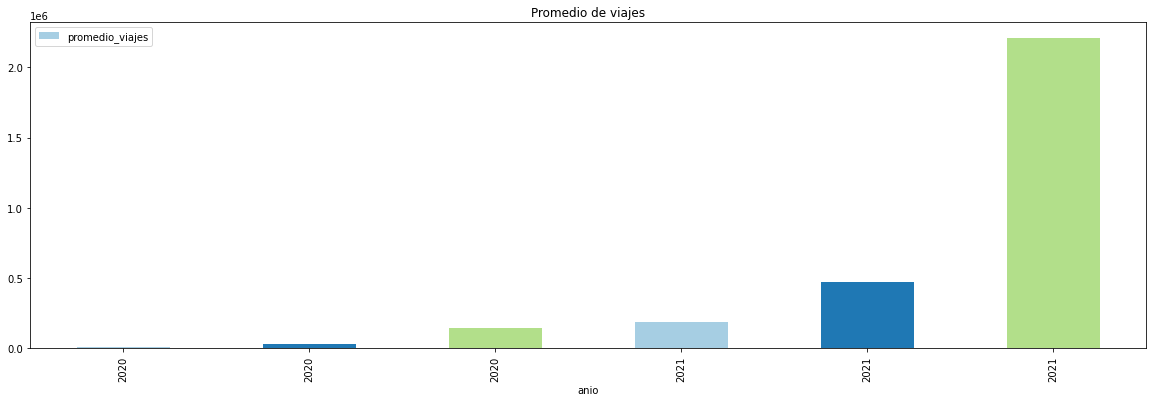

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

df_visual.plot.bar(x='anio', y='promedio_viajes', figsize=(20,6), color = plt.cm.Paired(range(3)), title = "Promedio de viajes");

In [25]:
dfsFecha.createOrReplaceTempView("data")
info2 = spark.sql("""
SELECT 
    TIPO_TRANSPORTE, anio, SUM(CANTIDAD) as viajes
FROM data
WHERE anio = 2020
GROUP BY TIPO_TRANSPORTE, anio
ORDER BY anio, TIPO_TRANSPORTE
""")

df_visual2 = info2.toPandas()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5c7d797dd8>],
      dtype=object)

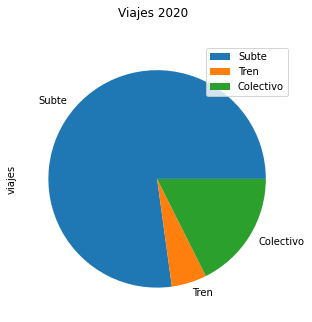

In [26]:
df_visual2.plot.pie( y='viajes',figsize=(5,5), labels = df_visual['TIPO_TRANSPORTE'], subplots = True, title = "Viajes 2020")